**What is BERT?**

BERT (introduced in this paper) stands for Bidirectional Encoder Representations from Transformers. If you don’t know what most of that means - you’ve come to the right place! Let’s unpack the main ideas:

- Bidirectional - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)

- Transformers - The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).

- (Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.
BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let’s look at examples of these tasks:

Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let’s look at an example, and try to not make it harder than it has to be:

That’s [mask] she [mask] -> That’s what she said

**Next Sentence Prediction (NSP)**

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let’s continue with the example:

Input = [CLS] That’s [mask] she [mask]. [SEP] Hahaha, nice! [SEP]

Label = IsNext

Input = [CLS] That’s [mask] she [mask]. [SEP] Dwight, you ignorant [mask]! [SEP]

Label = NotNext

The training corpus was comprised of two entries: Toronto Book Corpus (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

## **Setup**

In [ ]:
!pip install -qq transformers


import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We’ll load the Google Play app reviews dataset

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

df = pd.read_csv("reviews.csv")
df.head()

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 43.6MB/s]


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
print(df.shape)
print(df.info())

(15746, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
 11  sentiment             15746 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 1.4+ MB
None


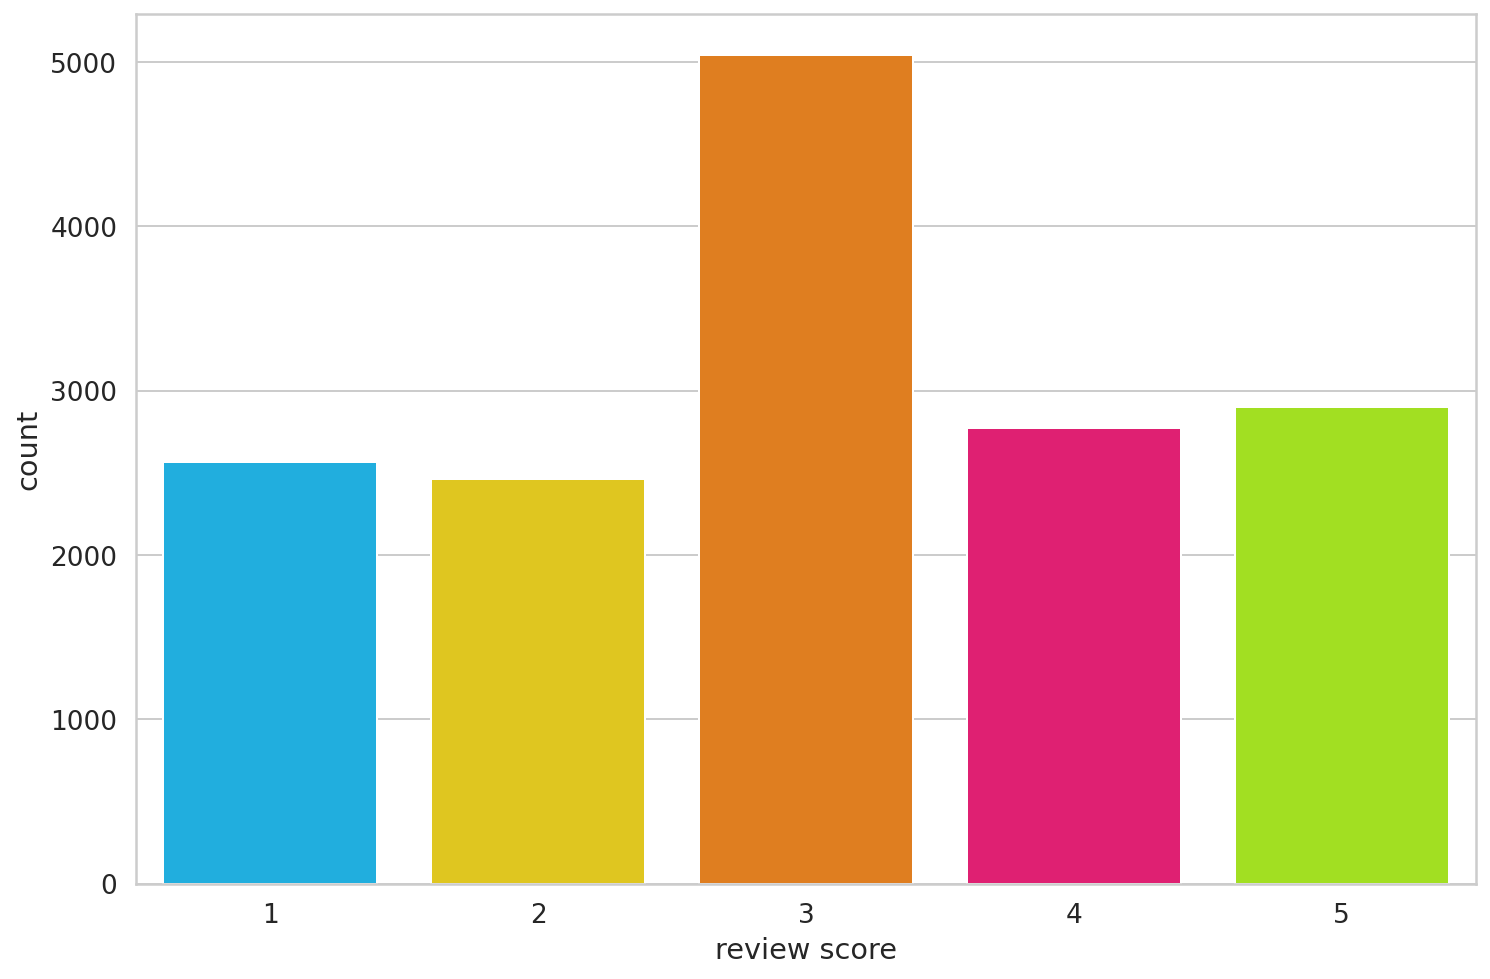

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

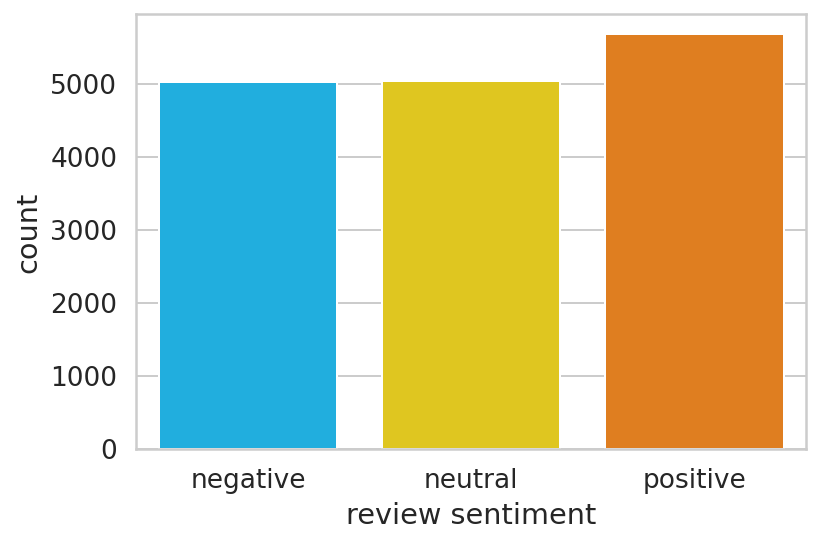

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# Data preprocessing
You might already know that Machine Learning models don’t work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides (you’ve guessed it) a wide variety of Transformer models (including BERT)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'The recently introduced continuous Skip-gram model is an efﬁcient method for learning high-quality distributed vector representations that capture a large number of precise syntactic and semantic word relationships. In this paper we present several extensions that improve both the quality of the vectors and the training speed. By subsampling of the frequent words we obtain signiﬁcant speedup and also learn more regular word representations. We also describe a simple alternative to the hierarchical softmax called negative sampling.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: The recently introduced continuous Skip-gram model is an efﬁcient method for learning high-quality distributed vector representations that capture a large number of precise syntactic and semantic word relationships. In this paper we present several extensions that improve both the quality of the vectors and the training speed. By subsampling of the frequent words we obtain signiﬁcant speedup and also learn more regular word representations. We also describe a simple alternative to the hierarchical softmax called negative sampling.
   Tokens: ['The', 'recently', 'introduced', 'continuous', 'Ski', '##p', '-', 'gram', 'model', 'is', 'an', 'e', '##f', '##ﬁ', '##cie', '##nt', 'method', 'for', 'learning', 'high', '-', 'quality', 'distributed', 'vector', 'representations', 'that', 'capture', 'a', 'large', 'number', 'of', 'precise', 's', '##yn', '##ta', '##ctic', 'and', 'semantic', 'word', 'relationships', '.', 'In', 'this', 'paper', 'we', 'present', 'several', 'extensions', 'that',

# Special tokens

In [ ]:
# mark fro ending of sentance
print(tokenizer.sep_token, tokenizer.sep_token_id)
# We must add this token to the start of each sentance, so BERT knows were doing classification 
print(tokenizer.cls_token, tokenizer.cls_token_id )
# padding token.
print(tokenizer.pad_token, tokenizer.pad_token_id )
# unknown token
print(tokenizer.unk_token, tokenizer.unk_token_id)



[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.values())
encoding.keys()


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_values([tensor([[  101,  1109,  3055,  2234,  6803, 16851,  1643,   118, 25968,  2235,
          1110,  1126,   174,  2087, 28987, 25982,  2227,  3442,  1111,  3776,
          1344,   118,  3068,  4901,  9479, 16539,  1115,  4821,   170,  1415,
          1295,   102]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])])


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1109,  3055,  2234,  6803, 16851,  1643,   118, 25968,  2235,
         1110,  1126,   174,  2087, 28987, 25982,  2227,  3442,  1111,  3776,
         1344,   118,  3068,  4901,  9479, 16539,  1115,  4821,   170,  1415,
         1295,   102])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

# split data

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
# Data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
print(data.keys())


print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
torch.Size([16, 160])
torch.Size([16, 160])

torch.Size([16, 160])
torch.Size([16, 160])


torch.Size([16, 160])

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

# Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);